# Step 1: Setup env, SQL connection and analyze SQL database data

Import necessary libraries when needed and establish connection to SQL database (noshow.db)

In [1]:
# Import libraries that are currently needed
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set path to SQL database
db_path = "../data/noshow.db"

# Create connection to SQL database
conn = sqlite3.connect(db_path)

# Set pandas options for better readbility
pd.set_option('display.max_columns', None) # Display all columns in DataFrame
pd.set_option('display.max_rows', 100) # Limit number of rows displayed

# Setup matplotlib and seaborn for inline visualization
%matplotlib inline
sns.set(style = "whitegrid")

Explore database structure by listing all available tables before further actions

In [2]:
# Query to list all tables in database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Display list of tables
tables

,name
0,noshow


Since there is only 'noshow' table in the database, the first few rows can be previewed to understand its structure

In [3]:
# Preview first few rows of 'noshow' table
noshow_query = "SELECT * FROM noshow LIMIT 10;"
df_noshow = pd.read_sql(noshow_query, conn)

# Display first 10 rows of table
df_noshow.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


The structure of 'noshow' table consists of following columns:
- booking_id (Unique value)
- no_show
- branch
- booking_month
- arrival_month
- arrival_day
- checkout_month
- checkout_day
- country
- first_time
- room (Drop missing values)
- price (Drop missing values)
- platform
- num_adults
- num_children

The schema of 'noshow' table is retrieved to understand the columns and their data types

In [4]:
# Get schema of 'noshow' table
schema_query = "PRAGMA table_info(noshow);"
schema_df = pd.read_sql(schema_query, conn)

# Display schema information
schema_df

,cid,name,type,notnull,dflt_value,pk
0,0,booking_id,INTEGER,0,None,0
1,1,no_show,REAL,0,None,0
2,2,branch,TEXT,0,None,0
3,3,booking_month,TEXT,0,None,0
4,4,arrival_month,TEXT,0,None,0
5,5,arrival_day,REAL,0,None,0
6,6,checkout_month,TEXT,0,None,0
7,7,checkout_day,REAL,0,None,0
8,8,country,TEXT,0,None,0
9,9,first_time,TEXT,0,None,0


From the schema, some columns can be seen to have TEXT type data so they will have to be converted to REAL type using one-hot encoding

# Step 2: Perform Exploratory Data Analysis (EDA) on 'noshow' table

Load all the data into a DataFrame to start data analysis

In [5]:
# Get all data from 'noshow' table
noshow_data_query = "SELECT * FROM noshow;"
noshow_data_df = pd.read_sql_query(noshow_data_query, conn)

Use booking_id to eliminate duplicate data as each row should be unique

In [6]:
noshow_data_df = noshow_data_df.drop_duplicates(subset = "booking_id", keep = "first")
noshow_data_df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0.0


Drop booking_id column after removing duplicates as each row is now unique

In [7]:
drop_col_noshow_data_df = noshow_data_df.drop(columns = "booking_id")

Clean-up rows with missing cell info <br>
Example: If cell in row has missing value, then row should be dropped

Firstly, check which columns have missing data

In [8]:
# Check number of rows that have missing data
missing_data = drop_col_noshow_data_df.isnull().sum()

# Display number of affected rows
print("Missing values in each column: ")
print(missing_data[missing_data > 0])

Missing values in each column: 
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64


Next, drop all rows that have missing values

In [9]:
# Drop rows if there are any missing values
cleaned_noshow_data_df = drop_col_noshow_data_df.dropna()

# Verify if all missing values are dropped
print("Missing values after dropping rows: ")
print(cleaned_noshow_data_df.isnull().sum())

Missing values after dropping rows: 
no_show           0
branch            0
booking_month     0
arrival_month     0
arrival_day       0
checkout_month    0
checkout_day      0
country           0
first_time        0
room              0
price             0
platform          0
num_adults        0
num_children      0
dtype: int64


Do manual data conversion for price and num_adults
- price (Convert all price to SGD$ and remove SGD$)
- num_adults (Convert string value to its integer value)

In [ ]:
# Assume USD$ to SGD$ conversion rate is 1:1.34
# Remove all USD$/SGD$ tags and create a new column called sgd_price
def convert_price(price):
    # Check if price is in USD/SGD
    if "USD$" in price:
        value = float(price.replace("USD$ ", "").strip())
        # Convert USD to SGD by multiplying by 1.34
        value = value * 1.34
    else:
        # Extract number after SGD$ and convert to float
        value = float(price.replace("SGD$ ", "").strip())
    return value

# Apply function to 'price' column and create new column with converted values named 'sgd_price'
cleaned_noshow_data_df["sgd_price"] = cleaned_noshow_data_df["price"].apply(convert_price)

# Drop 'price' column
cleaned_noshow_data_df = cleaned_noshow_data_df.drop(columns="price")

# Display DataFrame for post price conversion
cleaned_noshow_data_df

C:\Users\waele\AppData\Local\Temp\ipykernel_18912\394856918.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_noshow_data_df["sgd_price"] = cleaned_noshow_data_df["price"].apply(convert_price)


,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,sgd_price
0,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,Website,1,0.0,492.9800
1,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,Website,2,0.0,1351.2200
3,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,Website,1,0.0,666.0400
4,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,Website,1,0.0,891.5958
6,0.0,Orchard,November,October,15.0,October,16.0,Australia,Yes,King,Website,1,1.0,1375.4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119384,0.0,Changi,April,June,11.0,June,12.0,China,Yes,King,Agent,1,0.0,811.9194
119386,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,Website,1,1.0,820.3212
119387,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,Email,2,0.0,1395.3286
119388,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,Email,1,2.0,859.5698


In [11]:
# Convert string value in num_adults to float value
# Perform manual mapping after checking number of string values to replace
print("Unique values in 'num_adults' column - ")
print(cleaned_noshow_data_df["num_adults"].unique())

# There are only 'one' and 'two' string values in the column
number_mapping = {
    'one': 1,
    'two': 2
}

# Apply mapping to 'num_adults' column
cleaned_noshow_data_df["num_adults"] = cleaned_noshow_data_df["num_adults"].replace(number_mapping)

# Display DataFrame post mapping
cleaned_noshow_data_df

Unique values in 'num_adults' column - 
['1' '2' 'one' 'two']


,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,sgd_price
0,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,Website,1,0.0,492.9800
1,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,Website,2,0.0,1351.2200
3,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,Website,1,0.0,666.0400
4,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,Website,1,0.0,891.5958
6,0.0,Orchard,November,October,15.0,October,16.0,Australia,Yes,King,Website,1,1.0,1375.4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119384,0.0,Changi,April,June,11.0,June,12.0,China,Yes,King,Agent,1,0.0,811.9194
119386,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,Website,1,1.0,820.3212
119387,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,Email,2,0.0,1395.3286
119388,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,Email,1,2.0,859.5698


Perform standardization and one-hot encoding on feature data set

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standardize data-set
cleaned_noshow_data_df[["no_show", "arrival_day", "checkout_day", "num_adults", "num_children", "sgd_price"]] = scaler.fit_transform(cleaned_noshow_data_df[["no_show", "arrival_day", "checkout_day", "num_adults", "num_children", "sgd_price"]])

# Perform one-hot encoding on categorical variables
encoded_noshow_data_df = pd.get_dummies(cleaned_noshow_data_df, columns = ["branch", "booking_month", "arrival_month", "checkout_month", "country", "first_time", "room", "platform"], drop_first=True)
bool_col = encoded_noshow_data_df.select_dtypes(include=["bool"]).columns
encoded_noshow_data_df[bool_col] = encoded_noshow_data_df[bool_col].astype(int)
encoded_noshow_data_df

,no_show,arrival_day,checkout_day,num_adults,num_children,sgd_price,branch_Orchard,booking_month_August,booking_month_December,booking_month_February,booking_month_January,booking_month_July,booking_month_June,booking_month_March,booking_month_May,booking_month_November,booking_month_October,booking_month_September,arrival_month_AUgust,arrival_month_ApRiL,arrival_month_ApRil,arrival_month_AprIl,arrival_month_ApriL,arrival_month_April,arrival_month_AuGust,arrival_month_AugUst,arrival_month_AuguSt,arrival_month_AugusT,arrival_month_August,arrival_month_DEcember,arrival_month_DeCember,arrival_month_DecEMber,arrival_month_DecEmber,arrival_month_DeceMber,arrival_month_DecemBer,arrival_month_DecembEr,arrival_month_DecembeR,arrival_month_December,arrival_month_FEbruary,arrival_month_FeBruary,arrival_month_FebRuary,arrival_month_FebrUary,arrival_month_FebruAry,arrival_month_FebruaRY,arrival_month_FebruaRy,arrival_month_FebruarY,arrival_month_February,arrival_month_JAnuary,arrival_month_JUly,arrival_month_JUne,arrival_month_JaNuary,arrival_month_JanUary,arrival_month_JanuAry,arrival_month_JanuaRy,arrival_month_JanuarY,arrival_month_January,arrival_month_JuLy,arrival_month_JuNe,arrival_month_JulY,arrival_month_July,arrival_month_JunE,arrival_month_June,arrival_month_MAY,arrival_month_MArch,arrival_month_MAy,arrival_month_MaRch,arrival_month_MaY,arrival_month_MarCh,arrival_month_MarcH,arrival_month_March,arrival_month_May,arrival_month_NOvEmber,arrival_month_NOveMber,arrival_month_NOvember,arrival_month_NoVember,arrival_month_NovEmber,arrival_month_NoveMber,arrival_month_NovemBeR,arrival_month_NovemBer,arrival_month_NovembEr,arrival_month_NovembeR,arrival_month_November,arrival_month_OCTober,arrival_month_OCtober,arrival_month_OcTobeR,arrival_month_OcTober,arrival_month_OctOber,arrival_month_OctoBer,arrival_month_OctobEr,arrival_month_OctobeR,arrival_month_October,arrival_month_SEptember,arrival_month_SePtember,arrival_month_SepTember,arrival_month_SeptEmber,arrival_month_SepteMber,arrival_month_SeptemBer,arrival_month_SeptembEr,arrival_month_SeptembeR,arrival_month_September,checkout_month_August,checkout_month_December,checkout_month_February,checkout_month_January,checkout_month_July,checkout_month_June,checkout_month_March,checkout_month_May,checkout_month_November,checkout_month_October,checkout_month_September,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,room_President Suite,room_Queen,room_Single,platform_Email,platform_Phone,platform_Website
0,-0.767577,1.051713,1.152062,-0.855915,-1.118248,-1.695075,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1
1,-0.767577,1.393314,1.332112,1.168341,-1.118248,1.570013,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,1.302801,-1.681098,-1.008537,-0.855915,-1.118248,-1.036685,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1
4,-0.767577,0.482377,0.881987,-0.855915,-1.118248,-0.178581,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
6,-0.767577,-0.086958,0.161787,-0.855915,0.163848,1.662156,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

It can now be used to generate summary statistics to check on mean, median, 25%, etc

In [13]:
# Get summary statistics from 'noshow' DataFrame
summary_stats = encoded_noshow_data_df.describe()

# Display summary statistics
summary_stats

,no_show,arrival_day,checkout_day,num_adults,num_children,sgd_price,branch_Orchard,booking_month_August,booking_month_December,booking_month_February,booking_month_January,booking_month_July,booking_month_June,booking_month_March,booking_month_May,booking_month_November,booking_month_October,booking_month_September,arrival_month_AUgust,arrival_month_ApRiL,arrival_month_ApRil,arrival_month_AprIl,arrival_month_ApriL,arrival_month_April,arrival_month_AuGust,arrival_month_AugUst,arrival_month_AuguSt,arrival_month_AugusT,arrival_month_August,arrival_month_DEcember,arrival_month_DeCember,arrival_month_DecEMber,arrival_month_DecEmber,arrival_month_DeceMber,arrival_month_DecemBer,arrival_month_DecembEr,arrival_month_DecembeR,arrival_month_December,arrival_month_FEbruary,arrival_month_FeBruary,arrival_month_FebRuary,arrival_month_FebrUary,arrival_month_FebruAry,arrival_month_FebruaRY,arrival_month_FebruaRy,arrival_month_FebruarY,arrival_month_February,arrival_month_JAnuary,arrival_month_JUly,arrival_month_JUne,arrival_month_JaNuary,arrival_month_JanUary,arrival_month_JanuAry,arrival_month_JanuaRy,arrival_month_JanuarY,arrival_month_January,arrival_month_JuLy,arrival_month_JuNe,arrival_month_JulY,arrival_month_July,arrival_month_JunE,arrival_month_June,arrival_month_MAY,arrival_month_MArch,arrival_month_MAy,arrival_month_MaRch,arrival_month_MaY,arrival_month_MarCh,arrival_month_MarcH,arrival_month_March,arrival_month_May,arrival_month_NOvEmber,arrival_month_NOveMber,arrival_month_NOvember,arrival_month_NoVember,arrival_month_NovEmber,arrival_month_NoveMber,arrival_month_NovemBeR,arrival_month_NovemBer,arrival_month_NovembEr,arrival_month_NovembeR,arrival_month_November,arrival_month_OCTober,arrival_month_OCtober,arrival_month_OcTobeR,arrival_month_OcTober,arrival_month_OctOber,arrival_month_OctoBer,arrival_month_OctobEr,arrival_month_OctobeR,arrival_month_October,arrival_month_SEptember,arrival_month_SePtember,arrival_month_SepTember,arrival_month_SeptEmber,arrival_month_SepteMber,arrival_month_SeptemBer,arrival_month_SeptembEr,arrival_month_SeptembeR,arrival_month_September,checkout_month_August,checkout_month_December,checkout_month_February,checkout_month_January,checkout_month_July,checkout_month_June,checkout_month_March,checkout_month_May,checkout_month_November,checkout_month_October,checkout_month_September,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,room_President Suite,room_Queen,room_Single,platform_Email,platform_Phone,platform_Website
count,7.289700e+04,7.289700e+04,7.289700e+04,7.289700e+04,7.289700e+04,7.289700e+04,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,72897.00000,72897.000000,72897.000000,72897.000000,72897.000000,72897.000000,7289

# Step 3: Analyze the patterns and distributions in 'noshow' DataFrame

Plot heatmap for dimension reduction visualization

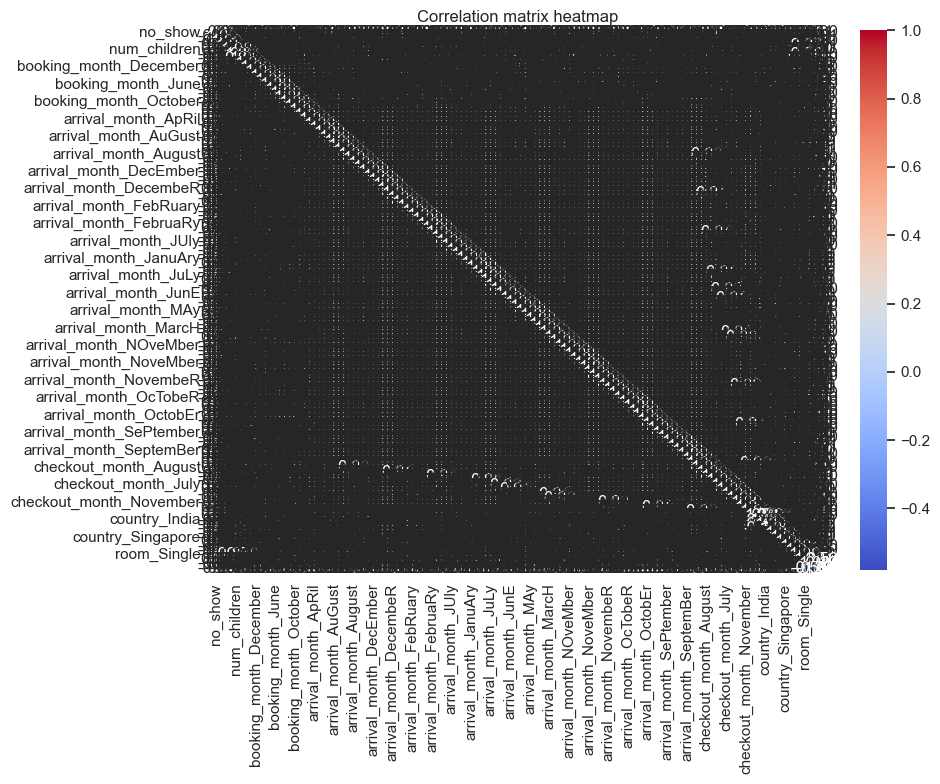

Correlation with 'no_show': 
no_show                    1.000000
country_China              0.341950
branch_Orchard             0.137955
country_India              0.123827
country_Japan              0.122210
                             ...   
arrival_month_SeptembEr    0.000384
arrival_month_AugUst       0.000354
arrival_month_JulY         0.000313
arrival_month_DecEmber     0.000181
arrival_month_MaY          0.000110
Name: no_show, Length: 124, dtype: float64


In [14]:
# Calculate correlation matrix
corr_matrix = encoded_noshow_data_df.corr()

# Create heatmap of correlation matrix
plt.figure(figsize = (10, 8)) # Adjust size as needed
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths=0.5)

# Show plot
plt.title("Correlation matrix heatmap")
plt.tight_layout()
plt.show()

no_show_corr = corr_matrix["no_show"]

# Sort correlations by absolute value (if strong correlations should be prioritized)
sorted_corr = no_show_corr.abs().sort_values(ascending=False)

# Print numerical correlation values
print("Correlation with 'no_show': ")
print(sorted_corr)

Drop features with correlation value < 0.1

In [15]:
drop_cols = sorted_corr[sorted_corr < 0.1].index

final_noshow_data_df = encoded_noshow_data_df.drop(columns = drop_cols, axis = 1)
final_noshow_data_df

,no_show,branch_Orchard,country_China,country_India,country_Indonesia,country_Japan
0,-0.767577,0,0,0,0,0
1,-0.767577,1,0,0,1,0
3,1.302801,1,1,0,0,0
4,-0.767577,1,0,0,0,0
6,-0.767577,1,0,0,0,0
...,...,...,...,...,...,...
119384,-0.767577,0,1,0,0,0
119386,-0.767577,0,1,0,0,0
119387,-0.767577,1,1,0,0,0
119388,1.302801,0,0,0,1,0


Testing ML for chosen features in final_noshow_data_df

In [16]:
X = final_noshow_data_df.drop(["no_show"], axis = 1)
Y = final_noshow_data_df["no_show"]

from sklearn.model_selection import train_test_split

# Split data into test and train (20/80 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Start with Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
lin_Y_predict = lin_model.predict(X_test)

lin_mse = mean_squared_error(Y_test, lin_Y_predict)
lin_r2 = r2_score(Y_test, lin_Y_predict)

print("Linear Regression - ")
print(f"Mean Squared Error: {lin_mse}")
print(f"R^2: {lin_r2}")

Linear Regression - 
Mean Squared Error: 0.8583228418264903
R^2: 0.13967186515348073


Next, try with Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

rand_for_model = RandomForestRegressor()
rand_for_model.fit(X_train, Y_train)
rand_for_Y_predict = rand_for_model.predict(X_test)

rand_for_mse = mean_squared_error(Y_test, rand_for_Y_predict)
rand_for_r2 = r2_score(Y_test, rand_for_Y_predict)

print("Pre-tuning Random Forest Regression - ")
print(f"Mean Squared Error: {rand_for_mse}")
print(f"R^2: {rand_for_r2}")

Pre-tuning Random Forest Regression - 
Mean Squared Error: 0.8552343160941195
R^2: 0.14276760658464405


Tune Random Forest for better results

In [19]:
def tune_n_eval_regressor(X, Y, search_method = "grid", param_grid = None, param_dist = None, random_iter = 50, cv = 5):
    """
    Automates the tuning and evaluation of a Random Forest Regressor model.

    Parameters:
        X: Features (DataFrame or array).
        y: Target variable (Series or array).
        search_method: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV.
        param_grid: Dictionary of hyperparameter ranges for GridSearchCV.
        param_dist: Dictionary of hyperparameter distributions for RandomizedSearchCV.
        random_iter: Number of iterations for RandomizedSearchCV.
        cv: Number of cross-validation folds.

    Returns:
        best_model: The tuned Random Forest Regressor model.
        best_params: The best hyperparameters found.
    """
    from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

    # Initialize parameters
    if param_grid is None:
        param_grid = {
            "n_estimators": [100, 150, 200, 250, 300, 350],
            "max_depth": [None, 5, 10, 15, 20],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    if param_dist is None:
        from scipy.stats import randint
        param_dist = {
            "n_estimators": randint(100, 500),
            "max_depth": [None, 5, 10, 15, 20, 25, 30],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 20)
        }

    if search_method == "grid":
        search = GridSearchCV(
            RandomForestRegressor(random_state = 42),
            param_grid = param_grid,
            cv = cv,
            scoring = "neg_mean_squared_error",
            n_jobs = 4
        )
    elif search_method == "random":
        search = RandomizedSearchCV(
            RandomForestRegressor(random_state = 42),
            param_distributions = param_dist,
            n_iter = random_iter,
            cv = cv,
            scoring = "neg_mean_squared_error",
            random_state = 42,
            n_jobs = 4
        )
    else:
        raise ValueError("search_method must be either 'grid' or ' random'")
    
    # Fit the search
    print(f"Running {search_method.capitalize()} Search...")
    search.fit(X_train, Y_train)

    # Best model and parameters
    best_model = search.best_estimator_
    best_params = search.best_params_
    print(f"\nBest Parameters: {best_params}")

    # Test set evaluation
    tuned_rand_for_Y_predict = best_model.predict(X_test)
    tuned_rand_for_mse = mean_squared_error(Y_test, tuned_rand_for_Y_predict)
    tuned_rand_for_r2 = r2_score(Y_test, tuned_rand_for_Y_predict)
    print("Tuned Random Forest Regression -")
    print(f"Tuned Set Mean Squared Error: {tuned_rand_for_mse:.4f}")
    print(f"Tuned Set R^2: {tuned_rand_for_r2:.4f}")

    # Plot scatter plot of actual vs predicted
    plt.figure(figsize = (8,6))
    plt.scatter(Y_test, tuned_rand_for_Y_predict, alpha = 0.7)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color = "red", linestyle = "--")
    plt.show()

    return best_model, best_params

Call tuning and evaluation function

Running Grid Search...

Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest Regression -
Tuned Set Mean Squared Error: 0.8552
Tuned Set R^2: 0.1428


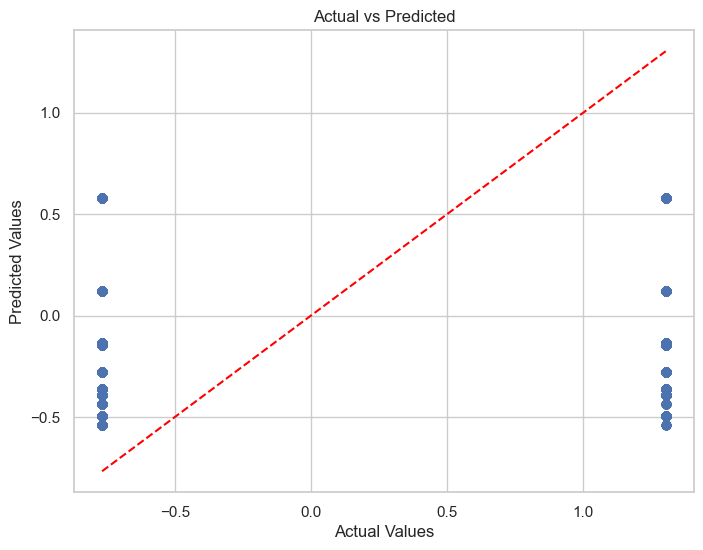

In [20]:
# Using Grid Search
grid_rand_for_best_model, grid_rand_for_best_param = tune_n_eval_regressor(
    X = final_noshow_data_df.drop(columns = ["no_show"]),
    Y = final_noshow_data_df["no_show"],
    search_method = "grid"
)

Running Random Search...

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 108}
Tuned Random Forest Regression -
Tuned Set Mean Squared Error: 0.8553
Tuned Set R^2: 0.1427


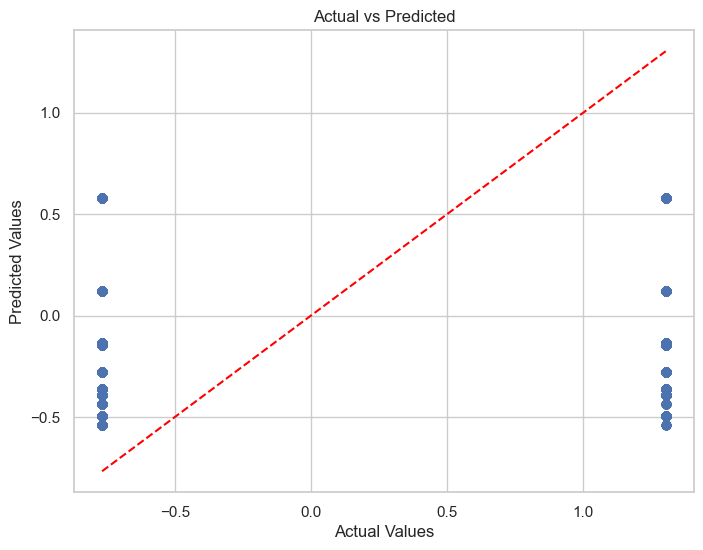

In [21]:
# Using Random Search
grid_rand_for_best_model, grid_rand_for_best_param = tune_n_eval_regressor(
    X = final_noshow_data_df.drop(columns = ["no_show"]),
    Y = final_noshow_data_df["no_show"],
    search_method = "random"
)

Use XGBoost for variation

In [22]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, Y_train)
xgb_Y_predict = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(Y_test, xgb_Y_predict)
xgb_r2 = r2_score(Y_test, xgb_Y_predict)

print("XGBoost - ")
print(f"Mean Squared Error: {xgb_mse:.4f}")
print(f"R^2: {xgb_r2:.4f}")

XGBoost - 
Mean Squared Error: 0.8553
R^2: 0.1428


Check variance and range of target variable - no_show

In [23]:
# Calculate variance of target variable
variance_no_show = Y_test.var() # Variance of actual target values
print(f"Variance of 'no_show': {variance_no_show:.3f}")

# Calculate range of target variable
range_no_show = Y_test.max() - Y_test.min()
print(f"Range of 'no_show': {range_no_show:.3f}")

Variance of 'no_show': 0.998
Range of 'no_show': 2.070


Perform ML with PCA (95% variance) features

In [24]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components = 0.95) # Keep 95% of variance
X_pca = pca.fit_transform(X)

print("Explained variance ratio: ", pca.explained_variance_ratio_)
print("Cumulative explained variance: ", np.cumsum(pca.explained_variance_ratio_))

pca_X_train, pca_X_test, pca_Y_train, pca_Y_test = train_test_split(X_pca, Y, test_size = 0.2, random_state = 42)
pca_model = RandomForestRegressor()
pca_model.fit(pca_X_train, pca_Y_train)

pca_Y_predict = pca_model.predict(pca_X_test)
pca_mse = mean_squared_error(pca_Y_test, pca_Y_predict)
pca_r2 = r2_score(pca_Y_test, pca_Y_predict)

print("PCA Random Forest Regression - ")
print(f"Mean Squared Error: {pca_mse}")
print(f"R^2: {pca_r2}")

Explained variance ratio:  [0.37601941 0.27155061 0.19963087 0.11485394]
Cumulative explained variance:  [0.37601941 0.64757003 0.8472009  0.96205484]
PCA Random Forest Regression - 
Mean Squared Error: 0.8552372158852353
R^2: 0.14276470001876862


Perform cross-validation with PCA feature

In [25]:
from sklearn.model_selection import cross_val_score
x_valid_model = RandomForestRegressor(random_state = 42)

# Perform 5-fold cross validation
scores = cross_val_score(x_valid_model, X, Y, cv=5, scoring="neg_mean_squared_error")

print(f"Cross-validation Mean Mean Squared Error: {-scores.mean():.4f}")
print(f"Cross-validation STD Mean Squared Error: {-scores.std():.4f}")

Cross-validation Mean Mean Squared Error: 0.8530
Cross-validation STD Mean Squared Error: -0.0042
